In [3]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [4]:
# Advertencias
import warnings
warnings.filterwarnings("ignore")

# Tratamiento de datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#Modelado
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#Evolucion
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [ ]:
#configuracion de colores
plt.style.use('fivethirtyeight')

In [5]:
#Importar datos 
# Datos
# Time: fecha y hora del registro del consumo
# Date: fecha del registrro del dato
# Demand: calor de la demanda de energia en MW
# Temperatura: temperatura del sitio
# Holiday: indica si el dia es o no festivo (incluye vacaciones)

url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv')
data = pd.read_csv(url)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [6]:
data.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [ ]:
#Transformar Time a fecha y hora
data['Time'] = pd.to_datetime(data['Time'], format = '%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('D')
data = data.sort_index()
data.head(20)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
2011-12-31 15:30:00,3865.597244,20.25,2012-01-01,True
2011-12-31 16:00:00,3694.097664,20.10,2012-01-01,True
2011-12-31 16:30:00,3561.623686,19.60,2012-01-01,True
2011-12-31 17:00:00,3433.035352,19.10,2012-01-01,True


In [ ]:
#Validar que el indice temporal esta completo
(data.index == pd.date_range(start = data.index.min(), end = data.index.max(), freq = data.index.freq)).all()

True

In [ ]:
data.index

DatetimeIndex(['2011-12-31 13:00:00', '2011-12-31 13:30:00',
               '2011-12-31 14:00:00', '2011-12-31 14:30:00',
               '2011-12-31 15:00:00', '2011-12-31 15:30:00',
               '2011-12-31 16:00:00', '2011-12-31 16:30:00',
               '2011-12-31 17:00:00', '2011-12-31 17:30:00',
               ...
               '2014-12-31 08:00:00', '2014-12-31 08:30:00',
               '2014-12-31 09:00:00', '2014-12-31 09:30:00',
               '2014-12-31 10:00:00', '2014-12-31 10:30:00',
               '2014-12-31 11:00:00', '2014-12-31 11:30:00',
               '2014-12-31 12:00:00', '2014-12-31 12:30:00'],
              dtype='datetime64[ns]', name='Time', length=52608, freq='30T')

In [ ]:
data.drop('Date',axis=1)
data = data.resample(rule = 'H', closed = 'left', label = 'right').mean()

In [ ]:
data.head(10)

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
2011-12-31 19:00:00,3317.992230,18.725,1.0
2011-12-31 20:00:00,3274.052232,18.675,1.0
2011-12-31 21:00:00,3432.421122,19.650,1.0
2011-12-31 22:00:00,3650.038153,21.775,1.0


In [ ]:
#Vonstruccion de conjuntos de entrenamiento, prueba y validacion
data = data.loc['2012-01-01 00:00:00' : '2014-12-30 23:00:00']
endTrain = '2013-12-31 23:59:00'
endTest = '2014-11-30 23:59:00'
dataTrain = data.loc[:endTrain, : ]
dataTest = data.loc[endTrain:endTest, : ]
validata = data.loc[endTest:, : ]

print(f'Train data: {dataTrain.index.min()} --- {dataTrain.index.max()} n = {len(dataTrain)}')
print(f'Test data: {dataTest.index.min()} --- {dataTest.index.max()} n = {len(dataTest)}')
print(f'validation data: {validata.index.min()} --- {validata.index.max()} n = {len(validata)}')

Train data: 2012-01-01 00:00:00 --- 2013-12-31 23:00:00 n = 17544
Test data: 2014-01-01 00:00:00 --- 2014-11-30 23:00:00 n = 8016
validation data: 2014-12-01 00:00:00 --- 2014-12-30 23:00:00 n = 720


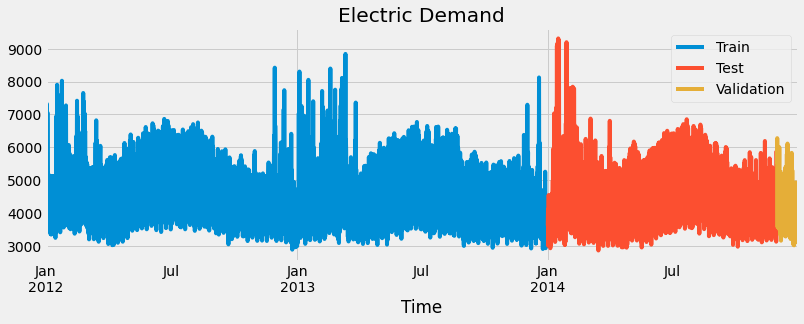

In [ ]:
#Grafica de la serie de tiempo
fig, ax = plt.subplots(figsize = (12,4))
dataTrain.Demand.plot(ax = ax, label = 'Train')
dataTest.Demand.plot(ax = ax, label = 'Test')
validata.Demand.plot(ax = ax, label = 'Validation')
ax.set_title('Electric Demand')
ax.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

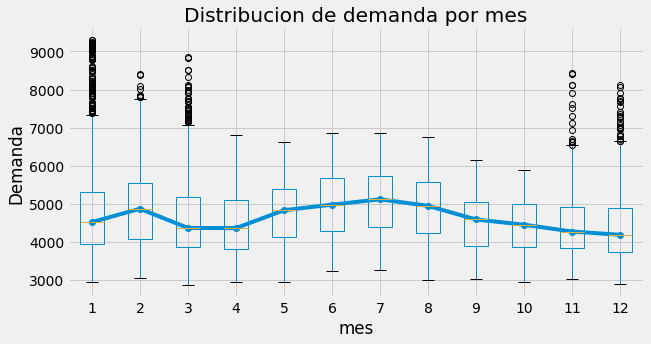

In [ ]:
#identificar la estacionalidad por mes
fig, ax = plt.subplots(figsize = (10,5))
data['mes'] = data.index.month
data.boxplot(column = 'Demand', by = 'mes',ax =ax)
data.groupby('mes')['Demand'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribucion de demanda por mes')
fig.suptitle('')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

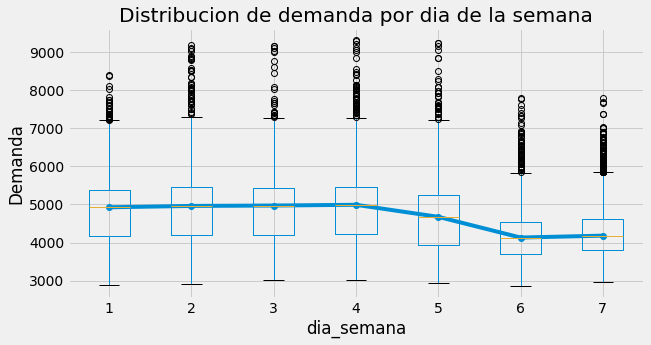

In [ ]:
#identificar la estacionalidad por dia semana
fig, ax = plt.subplots(figsize = (10,5))
data['dia_semana'] = data.index.day_of_week+1
data.boxplot(column = 'Demand', by = 'dia_semana',ax =ax)
data.groupby('dia_semana')['Demand'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribucion de demanda por dia de la semana')
fig.suptitle('')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

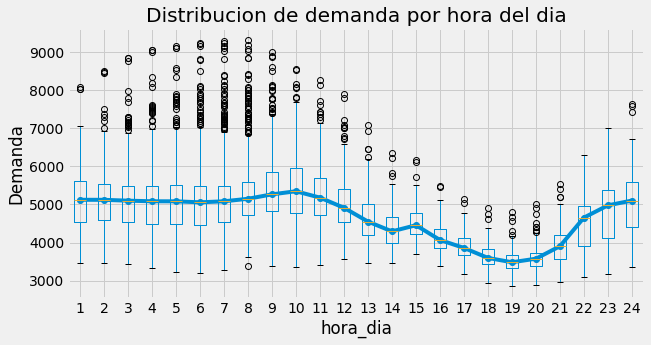

In [ ]:
#identificar la estacionalidad por hora del dia
fig, ax = plt.subplots(figsize = (10,5))
data['hora_dia'] = data.index.hour+1
data.boxplot(column = 'Demand', by = 'hora_dia',ax =ax)
data.groupby('hora_dia')['Demand'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribucion de demanda por hora del dia')
fig.suptitle('')
plt.show

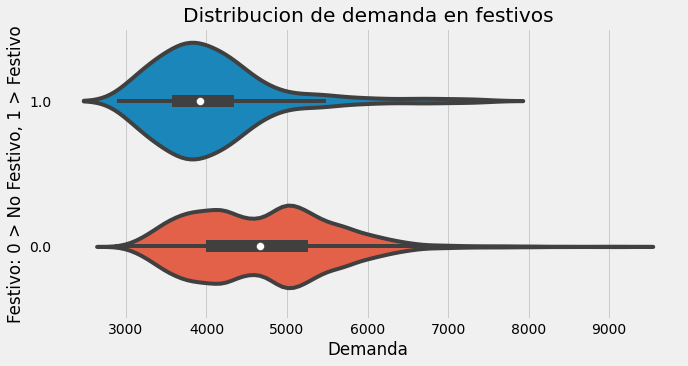

In [ ]:
#efecto de los dias festivos
fix, ax =plt.subplots(figsize = (10,5))
sb.violinplot(x = 'Demand',
              y = 'Holiday',
              data = data.assign(Holiday = data.Holiday.astype(str)),
              ax = ax)
ax.set_xlabel('Demanda')
ax.set_title('Distribucion de demanda en festivos')
ax.set_ylabel('Festivo: 0 > No Festivo, 1 > Festivo')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

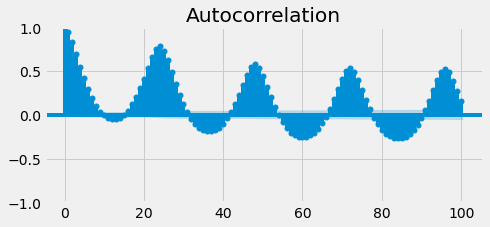

In [ ]:
#Grafico de autocorrelacion
fig, ax = plt.subplots(figsize = (7,3))
plot_acf(data.Demand, ax = ax, lags = 100 )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

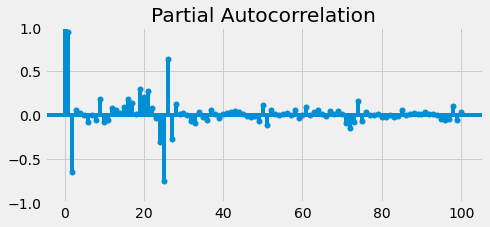

In [ ]:
#Grafico de Autocorrelacion parcial
fig, ax = plt.subplots(figsize = (7,3))
plot_pacf(data.Demand, ax = ax, lags = 100 )
plt.show

In [ ]:
#Modelado
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = data.loc[:endTest,'Demand'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Creation date: 2023-03-15 13:53:52 
Last fit date: 2023-03-15 13:53:53 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = data.Demand,
                                              initial_train_size = len(data.loc[:endTest]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Data partition in fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Data partition in fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Data partition in fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Data partition in fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 201

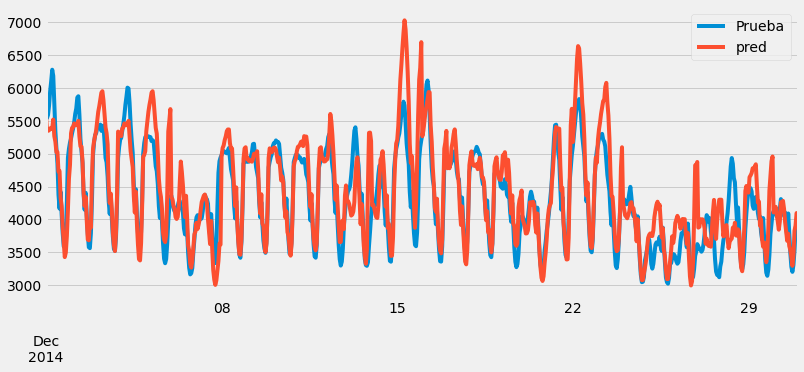

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
data.loc[predicciones.index,'Demand'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

283.2225270319444

In [ ]:
#Busqueda de hiperparametros
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = data.loc[:endTest,'Demand'])
#Logs utilizados compredictores
lags_grid = [5,24, [1,2,3,23,24,25,47,48,49]]
#hiperparametros del regressor
param_grid = {'max_depth':[5,9,7,11],
       'criterion':['squared_error','absolute_error']}
results_grid = grid_search_forecaster(forecaster = forecaster, 
                                      y = data.loc[:endTest, 'Demand'],
                                      param_grid = param_grid,
                                      lags_grid = lags_grid,
                                      steps = 24,
                                      metric = 'mean_absolute_error',
                                      refit = False, 
                                      initial_train_size = len(data[:endTrain]),
                                      fixed_train_size = False,
                                      return_best = True,
                                      verbose = False)

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:34<00:00, 91.50s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 9}
  Backtesting metric: 329.0992441341102



In [ ]:
results_grid

,lags,params,mean_absolute_error,criterion,max_depth
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 9}",329.099244,squared_error,9
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 7}",331.951363,absolute_error,7
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 11}",334.810303,squared_error,11
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 9}",351.954794,absolute_error,9
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 11}",352.695792,absolute_error,11
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 7}",356.786774,squared_error,7
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'absolute_error', 'max_depth': 5}",389.729629,absolute_error,5
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 5}",438.712625,squared_error,5
17,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 9}",477.306688,squared_error,9
19,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 11}",496.378953,squared_error,11


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=9) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Creation date: 2023-03-15 14:23:49 
Last fit date: 2023-03-15 14:28:25 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = data.Demand,
                                              initial_train_size = len(data.loc[:endTest]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = False)

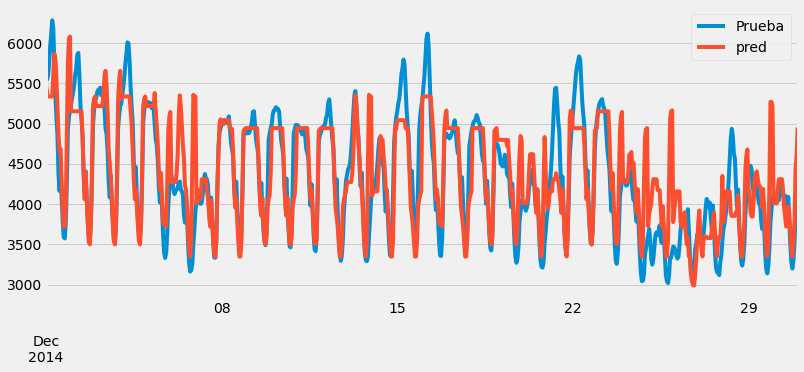

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
data.loc[predicciones.index,'Demand'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

282.99137138607813

In [ ]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.907809
1,lag_2,0.006741
2,lag_3,0.007567
3,lag_4,0.001358
4,lag_5,0.002696
5,lag_6,0.000969
6,lag_7,0.001318
7,lag_8,0.002373
8,lag_9,0.003157
9,lag_10,0.001382
